# Quick start

This notebooks looks at the main `striplog` object. For the basic objects it depends on, see [Basic objects](./02_Basic_objects.ipynb).

First, import anything we might need.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import striplog
striplog.__version__

'unknown'

## Making a striplog from CSV data

Suppose we have CSV data like this:

In [2]:
csv_string = """top, base, comp lithology, comp grainsize
  230.329,  233.269,  Grey sandstone, vf-f
  233.269,  234.700,  Anhydrite,
  234.700,  236.596,  Dolomite,
  236.596,  237.911,  Red siltstone,
  237.911,  238.723,  Anhydrite,
  238.723,  239.807,  Grey sandstone, vf-f
  239.807,  240.774,  Red siltstone,
  240.774,  241.122,  Dolomite,
  241.122,  241.702,  Grey siltstone,
  241.702,  243.095,  Dolomite,
"""

Because the lithology column is named **comp lithology** (or **component lithology**), striplog will interpret this column as the lithology of a component. Likewise, the grainsize is pulled out as another property. However, the colour of the rock is not pulled out -- it remains combined with the lithology.

In [5]:
from striplog import Striplog

strip = Striplog.from_csv(text=csv_string)

/home/matt/miniconda3/envs/welly/lib/python3.9/site-packages/striplog/striplog.py:512: UserWarning: No lexicon provided, using the default.
  warnings.warn(w)


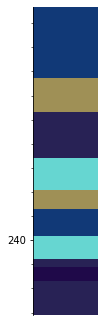

In [6]:
strip.plot(aspect=3)

Later we'll see how to make this plot look nicer.

Let's look at one **interval** of the striplog. We'll choose the first one, because it has the grainsize property. It looks like this:

In [7]:
strip[0]

Interval({'top': Position({'middle': 230.329, 'units': 'm'}), 'base': Position({'middle': 233.269, 'units': 'm'}), 'description': '', 'data': {}, 'components': [Component({'lithology': 'Grey sandstone', 'grainsize': 'vf-f'})]})

## Adding a lexicon

Often, we don't have properties conveniently separated out into columns like the example above. Instead we have data like:

    Light grey vf sandstone

We can get `striplog` to pull these different properties apart for us, by using a `Lexicon`. This is a dictionary-like look-up table that tells Striplog what different words mean. For example, using the default lexicon, here are the things it understands to be 'lithologies':

In [9]:
from striplog import Lexicon

lexicon = Lexicon.default()

lexicon.lithology

['overburden',
 'sandstone',
 'siltstone',
 'shale',
 'conglomerate',
 'mudstone',
 'limestone',
 'dolomite',
 'salt',
 'halite',
 'anhydrite',
 'gypsum',
 'sylvite',
 'clay',
 'mud',
 'silt',
 'sand',
 'gravel',
 'boulders']

And grainsize (these use regular expressions to capture variance in how grainsize might be expressed; all of them are case insensitive):

In [10]:
lexicon.grainsize

['vf(?:-)?',
 'f(?:-)?',
 'm(?:-)?',
 'c(?:-)?',
 'vc',
 'very fine(?: to)?',
 'fine(?: to)?',
 'medium(?: to)?',
 'coarse(?: to)?',
 'very coarse',
 'v fine(?: to)?',
 'med(?: to)?',
 'med.(?: to)?',
 'v coarse',
 'grains?',
 'granules?',
 'pebbles?',
 'cobbles?',
 'boulders?']

Now we can accept data in which the descriptions combine several properties:

In [11]:
csv_string = """top, base, description
  200.000,  230.329,  Anhydrite                                       
  230.329,  233.269,  Grey vf-f sandstone
  233.269,  234.700,  Anhydrite                                       
  234.700,  236.596,  Dolomite                                        
  236.596,  237.911,  Red siltstone                                   
  237.911,  238.723,  Anhydrite                                       
  238.723,  239.807,  Grey vf-f sandstone                             
  239.807,  240.774,  Red siltstone                                   
  240.774,  241.122,  Dolomite                                        
  241.122,  241.702,  Grey siltstone                                  
  241.702,  243.095,  Dolomite                                        
  243.095,  246.654,  Grey vf-f sandstone                             
  246.654,  247.234,  Dolomite                                        
  247.234,  255.435,  Grey vf-f sandstone                             
  255.435,  258.723,  Grey siltstone                                  
  258.723,  259.729,  Dolomite                                        
  259.729,  260.967,  Grey siltstone                                  
  260.967,  261.354,  Dolomite                                        
  261.354,  267.041,  Grey siltstone                                  
  267.041,  267.350,  Dolomite                                        
  267.350,  274.004,  Grey siltstone                                  
  274.004,  274.313,  Dolomite                                        
  274.313,  294.816,  Grey siltstone                                  
  294.816,  295.397,  Dolomite                                        
  295.397,  296.286,  Limestone                                       
  296.286,  300.000,  Volcanic                                        
"""

Let's see how the lexicon parses one of these 'descriptions':

In [13]:
from striplog import Component

Component.from_text('Light grey vf-f sandstone', lexicon)

Component({'lithology': 'sandstone', 'grainsize': 'vf-f', 'colour': 'light grey'})

Now we can pass in the CSV text and apply the lexicon to it, producing a striplog:

In [14]:
strip2 = Striplog.from_csv(text=csv_string, lexicon=lexicon, )
strip2

Striplog(26 Intervals, start=200.0, stop=300.0)

In [15]:
strip2[1]

Interval({'top': Position({'middle': 230.329, 'units': 'm'}), 'base': Position({'middle': 233.269, 'units': 'm'}), 'description': 'Grey vf-f sandstone', 'data': {}, 'components': [Component({'lithology': 'sandstone', 'grainsize': 'vf-f', 'colour': 'grey'})]})

## Making a `striplog` from an image

We originally made `striplog` for a specific use-case: we had a lot of images of striplogs, with tops and bottom depths. So striplog can read images and try to make striplog objects out of them:

Here is one of the images we will convert into striplogs:

<img src="https://raw.githubusercontent.com/agile-geoscience/striplog/master/docs/tutorial/M-MG-70_14.3_135.9.png" width=50 style="float:left" />

In [16]:
imgfile = "M-MG-70_14.3_135.9.png"

Striplog's `Legend` class maps 'components' (rocks, if you will) to display styles (colour, width, etc). We will eventually use a legend to control how striplogs are displayed, but a legend can also control how a striplog image is interpreted.

In [17]:
from striplog import Legend

legend = Legend.builtin('NSDOE')

In [18]:
strip = Striplog.from_image(imgfile, 14.3, 135.9, legend=legend)
strip

Striplog(26 Intervals, start=14.3, stop=135.9)

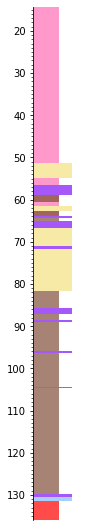

In [19]:
strip.plot(legend, ladder=True, aspect=5)

This thing might look like the image (because it uses the same legend), but it's data:

In [20]:
strip[0]

Interval({'top': Position({'middle': 14.3, 'units': 'm'}), 'base': Position({'middle': 51.24117647058824, 'units': 'm'}), 'description': '', 'data': {}, 'components': [Component({'lithology': 'anhydrite'})]})

## Representations of a `striplog`

There are several ways to inspect a striplog:

* **`print`** prints the contents of the striplog
* **`unique`** shows us a list of the primary lithologies in the striplog, in order of cumulative thickness
* **`histogram`** makes a histogram of the lithologies (and also returns the histogram data)
* **`plot`** makes a plot of the striplog with coloured bars

In [21]:
print(strip[:5])

{'top': Position({'middle': 14.3, 'units': 'm'}), 'base': Position({'middle': 51.24117647058824, 'units': 'm'}), 'description': '', 'data': {}, 'components': [Component({'lithology': 'anhydrite'})]}
{'top': Position({'middle': 51.24117647058824, 'units': 'm'}), 'base': Position({'middle': 54.81764705882354, 'units': 'm'}), 'description': '', 'data': {}, 'components': [Component({'lithology': 'sandstone', 'colour': 'grey', 'grainsize': 'vf-f'})]}
{'top': Position({'middle': 54.81764705882354, 'units': 'm'}), 'base': Position({'middle': 56.55882352941177, 'units': 'm'}), 'description': '', 'data': {}, 'components': [Component({'lithology': 'anhydrite'})]}
{'top': Position({'middle': 56.55882352941177, 'units': 'm'}), 'base': Position({'middle': 58.86470588235295, 'units': 'm'}), 'description': '', 'data': {}, 'components': [Component({'lithology': 'dolomite'})]}
{'top': Position({'middle': 58.86470588235295, 'units': 'm'}), 'base': Position({'middle': 60.464705882352945, 'units': 'm'}), 

In [22]:
strip.unique

[(Component({'lithology': 'siltstone', 'colour': 'grey'}), 46.16470588235293),
 (Component({'lithology': 'anhydrite'}), 39.67058823529412),
 (Component({'lithology': 'sandstone', 'colour': 'grey', 'grainsize': 'vf-f'}),
  19.200000000000003),
 (Component({'lithology': 'dolomite'}), 8.282352941176498),
 (Component({'lithology': 'volcanic'}), 4.42352941176469),
 (Component({'lithology': 'siltstone', 'colour': 'red'}), 2.7764705882352843),
 (Component({'lithology': 'limestone'}), 1.082352941176481)]

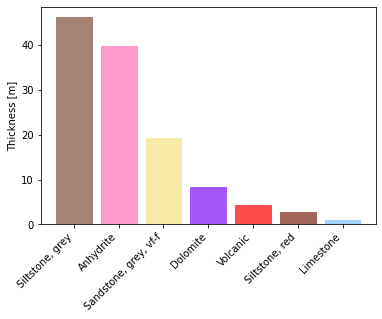

In [23]:
_ = strip.histogram(legend=legend, rotation=45, ha='right')

You have already seen some basic plotting. For more control, you can pass some parameters to the `Striplog.plot()` method, but all of them are optional.

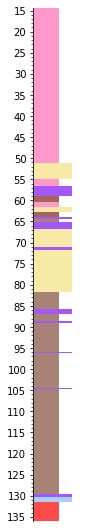

In [27]:
strip.plot(legend, ladder=True, aspect=5, ticks=5)

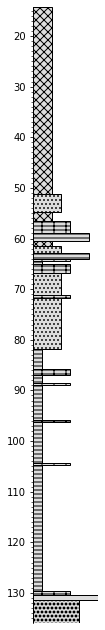

In [28]:
hashy_csv = """colour,width,hatch,component colour,component grainsize,component lithology
#dddddd,1,---,grey,,siltstone,
#dddddd,2,xxx,,,anhydrite,
#dddddd,3,...,grey,vf-f,sandstone,
#dddddd,4,+--,,,dolomite,
#dddddd,5,ooo,,,volcanic,
#dddddd,6,---,red,,siltstone,
#dddddd,7,,,,limestone,
"""
hashy = Legend.from_csv(text=hashy_csv)
strip.plot(hashy, ladder=True, aspect=6, lw=1)

## Manipulating a `striplog`

Again, the object is indexable and iterable.

In [29]:
print(strip[:3])

{'top': Position({'middle': 14.3, 'units': 'm'}), 'base': Position({'middle': 51.24117647058824, 'units': 'm'}), 'description': '', 'data': {}, 'components': [Component({'lithology': 'anhydrite'})]}
{'top': Position({'middle': 51.24117647058824, 'units': 'm'}), 'base': Position({'middle': 54.81764705882354, 'units': 'm'}), 'description': '', 'data': {}, 'components': [Component({'lithology': 'sandstone', 'colour': 'grey', 'grainsize': 'vf-f'})]}
{'top': Position({'middle': 54.81764705882354, 'units': 'm'}), 'base': Position({'middle': 56.55882352941177, 'units': 'm'}), 'description': '', 'data': {}, 'components': [Component({'lithology': 'anhydrite'})]}


In [30]:
print(strip[-1].primary.summary())

Volcanic


In [31]:
for i in strip[:5]:
    print(i.summary())

36.94 m of anhydrite
3.58 m of sandstone, grey, vf-f
1.74 m of anhydrite
2.31 m of dolomite
1.60 m of siltstone, red


In [32]:
import numpy as np

np.array([d.top.z for d in strip[5:13]])

array([60.46470588, 61.45294118, 62.77058824, 63.94705882, 64.37058824,
       65.07647059, 66.77058824, 71.1       ])

Slicing returns a new `striplog`:

In [33]:
strip[1:3]

Striplog(2 Intervals, start=51.24117647058824, stop=56.55882352941177)

You can even index into it with an iterable, like a list of indices. The result is a striplog.

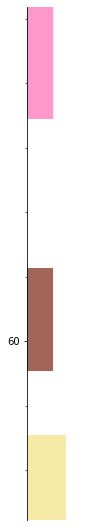

In [34]:
indices = [2,4,6]
strip[indices].plot(legend, aspect=5)

You can add striplogs:

In [35]:
strip[:5] + strip[-5:]

Striplog(10 Intervals, start=14.3, stop=135.9)

## Striplog from LAS data

Suppose we have LAS 3.0 data like this:

In [36]:
las3 = """~Lithology_Parameter
LITH .                    : Lithology source          {S}
LITHD.   MD               : Lithology depth reference {S}

~Lithology_Definition
LITHT.M                   : Lithology top depth       {F}
LITHB.M                   : Lithology base depth      {F}
LITHN.                    : Lithology name            {S}

~Lithology_Data | Lithology_Definition
  200.000,  230.329,  Anhydrite                                       
  230.329,  233.269,  Grey vf-f sandstone                             
  233.269,  234.700,  Anhydrite                                       
  234.700,  236.596,  Dolomite                                        
  236.596,  237.911,  Red siltstone                                   
  237.911,  238.723,  Anhydrite                                       
  238.723,  239.807,  Grey vf-f sandstone                             
  239.807,  240.774,  Red siltstone                                   
  240.774,  241.122,  Dolomite                                        
  241.122,  241.702,  Grey siltstone                                  
  241.702,  243.095,  Dolomite                                        
  243.095,  246.654,  Grey vf-f sandstone                             
  246.654,  247.234,  Dolomite                                        
  247.234,  255.435,  Grey vf-f sandstone                             
  255.435,  258.723,  Grey siltstone                                  
  258.723,  259.729,  Dolomite                                        
  259.729,  260.967,  Grey siltstone                                  
  260.967,  261.354,  Dolomite                                        
  261.354,  267.041,  Grey siltstone                                  
  267.041,  267.350,  Dolomite                                        
  267.350,  274.004,  Grey siltstone                                  
  274.004,  274.313,  Dolomite                                        
  274.313,  294.816,  Grey siltstone                                  
  294.816,  295.397,  Dolomite                                        
  295.397,  296.286,  Limestone                                       
  296.286,  300.000,  Volcanic                                        
"""

There is a method for this format:

In [37]:
strip3 = Striplog.from_las3(las3, lexicon)
strip3

Striplog(26 Intervals, start=200.0, stop=300.0)

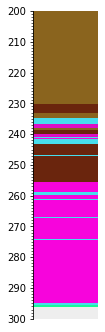

In [38]:
strip3.plot(aspect=3)

We can also produce a file like this from a striplog:

In [39]:
print(strip3.to_las3())

~Lithology_Parameter
LITH .   Striplog         : Lithology source          {S}
LITHD.   MD               : Lithology depth reference {S}

~Lithology_Definition
LITHT.M                   : Lithology top depth       {F}
LITHB.M                   : Lithology base depth      {F}
LITHD.                    : Lithology description     {S}

~Lithology_Data | Lithology_Definition
200.0,230.329,Anhydrite
230.329,233.269,"Sandstone, vf-f, grey"
233.269,234.7,Anhydrite
234.7,236.596,Dolomite
236.596,237.911,"Siltstone, red"
237.911,238.723,Anhydrite
238.723,239.807,"Sandstone, vf-f, grey"
239.807,240.774,"Siltstone, red"
240.774,241.122,Dolomite
241.122,241.702,"Siltstone, grey"
241.702,243.095,Dolomite
243.095,246.654,"Sandstone, vf-f, grey"
246.654,247.234,Dolomite
247.234,255.435,"Sandstone, vf-f, grey"
255.435,258.723,"Siltstone, grey"
258.723,259.729,Dolomite
259.729,260.967,"Siltstone, grey"
260.967,261.354,Dolomite
261.354,267.041,"Siltstone, grey"
267.041,267.35,Dolomite
267.35,274.004,"Si

<hr />

<p style="color:gray">©2022 Agile Geoscience. Licensed CC-BY. <a href="https://github.com/agile-geoscience/striplog">striplog.py</a></p>